# Code zu Lanczos-Verfahren mithilfe von QR-Verfahren

In [136]:
import numpy as np
from scipy.stats import unitary_group
from scipy.linalg import block_diag
from scipy.linalg import qr
import time
import matplotlib.pyplot as plt

### Funktionen zum generiern von Matrizen

In [173]:
def gen_hess(n, compl = False):
    if compl:
        a = np.random.rand(n) + np.random.rand(n)*1j
        b = np.random.rand(n-1) + np.random.rand(n-1)*1j
        c = np.random.rand(n-1) + np.random.rand(n-1)*1j
        return np.diag(b, -1) + np.diag(a,0) + np.diag(c, 1)
    else:
        A = np.zeros((n,n))
        a = np.random.rand(n)*50
        A = A + np.diag(a)
        for j in range(n-1):
            b = np.random.rand(n-j-1)*50
            A = A + np.diag(b,j+1)
        return np.diag(np.random.rand(n-1)*50, -1) + A
    

def gen_upper_tri(eig, compl = False):
    n = eig.shape[0]
    if compl:
        return np.triu(np.random.rand(n,n) + np.random.rand(n,n) * 1j, 1) + np.diag(eig)
    else:
        return np.triu(np.random.rand(n,n),1) + np.diag(eig)
    

def gen_hermite(eig, compl = False):
    n = eig.shape[0]
    B = unitary_group.rvs(n)
    return B.T.conj()@np.diag(eig)@B


def gen_rand_mat(eig, compl = False):
    n = eig.shape[0]
    if compl:
        B = np.random.rand(n,n) + np.random.rand(n,n)*compl*1j
    else:
        B = np.random.rand(n,n)
    return np.linalg.inv(B)@np.diag(eig)@B



#print(gen_hess(5))
#print(gen_upper_tri(np.array([1,2,3]), True))
#print(gen_hermite(np.array([1,2,3,4])))
#print(gen_rand_mat(np.array([1,2,7,4])))



### Verfahren implementiert

In [184]:
def QR_simple(A,tol = 1e-6):
    count = 0
    while abs(A[1,0]) > tol:
        Q,R = np.linalg.qr(A)
        A = R@Q
        count +=1
    return A, sorted(np.diag(A)) ,count



def QR_shift(A,tol=1e-10):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol:
            rho = A[i,i]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count +=1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_shift2(A,tol=1e-12):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = np.linalg.qr(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_hesse(A,tol=1e-12):
    n = A.shape[1]
    count = 0
    for i in range(n-1,0,-1):
        while abs(A[i,i-1]) > tol*(abs(A[i-1,i-1])+abs(A[i,i])):
            w = np.linalg.eigvals(A[i-1:i+1,i-1:i+1])
            if abs(w[0] - A[i,i]) < abs(w[1] - A[i,i]):
                rho = w[0]
            else:
                rho = w[1]
            Q,R = QR_decomp_hesse(A-rho*np.identity(n))
            A = R@Q + rho*np.identity(n)
            count += 1
        A[i,:i-n] = 0
    return A, sorted(np.diag(A)), count



def QR_decomp_hesse(A):
    n = A.shape[0]
    Q = np.eye(n,n)
    
    for i in range(0,n-1):
        if abs(A[i,i]) >= abs(A[i+1,i]):
            t = A[i+1,i]/abs(A[i,i])
            root = (1+abs(t)**2)**(1/2)
            c = A[i,i]/(abs(A[i,i])*root)
            s = t/root
        else:
            t = A[i,i]/abs(A[i+1,i])
            root = (1+abs(t)**2)**(1/2)
            s = A[i+1,i]/(abs(A[i+1,i])*root)
            c = t/root
      
        for j in range(n):
            if j < i:
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]
            else:
                temp_1 = A[i,j]
                A[i,j] = c.conj()*temp_1 + s.conj()*A[i+1,j]
                A[i+1,j] = -s*temp_1 + c*A[i+1,j]
                temp_2 = Q[i,j]
                Q[i,j] = c.conj()*temp_2 + s.conj()*Q[i+1,j]
                Q[i+1,j] = -s*temp_2 + c*Q[i+1,j]
    
    return Q.T.conj(), A



def lanczos(A,k = 0):
    n = A.shape[1]
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    gam = [v[0].T.conj()@A@v[0]]
    w = (A - gam[0]*np.identity(n))@v[0]
    delta = [np.linalg.norm(w)]
    i = 0
    while delta[i] > 1e-10 and i < k-1:
        v.append(w/delta[i])
        i +=1
        gam.append(v[i].T.conj()@A@v[i])
        w = (A - gam[i]*np.identity(n))@v[i] - delta[i-1]*v[i-1]
        delta.append(np.linalg.norm(w))
    T = np.diag(delta[:-1], -1) + np.diag(gam) + np.diag(delta[:-1], 1)
    return QR_hesse(T)

def arnoldi(A, dim, k = 0):
    n = dim
    if k == 0:
        k = n
        
    v0 = np.random.rand(n)
    v = [v0/np.linalg.norm(v0)]
    h = np.zeros((k,k))
    
    for j in range(k):
        w = A(v[j])
        for l in range(j+1):
            h[l][j] = w.T.conj()@v[l]
            w = w - h[l][j]*v[l]
        if j < k-1:
            h[j+1][j] = np.sqrt(w.T.conj()@w)
            if abs(h[j+1][j]) < 1e-14:
                return QR_hesse(h[:j+1,:j+1])
            else:
                v.append(w/h[j+1][j])
    return QR_hesse(h)

### Testing

In [234]:
def error(eig_1, eig_2):
    eig_1 = np.sort(eig_1)
    eig_2 = np.sort(eig_2)
    return np.linalg.norm(eig_1 - eig_2)


def runtime(f,A):
    start = time.time()
    f(A)
    end = time.time()
    return end - start

def runtime_error(f,A):
    start = time.time()
    S = f(A)
    end = time.time()
    return end - start, S

def runtime_error_lanczos(f,A,k):
    start = time.time()
    S = f(A,k)
    end = time.time()
    return end - start, S

def testing(f, n_1, n_2):
    n_array = np.array([i for i in range(n_1,n_2)])
    time_array = []
    error_array = []
    for n in n_array:
        eigv = np.sort(50*np.random.rand(n)-25)
        A = gen_hermite(eigv)
        t, A = runtime_error(f,A)
        err = error(A[1], eigv)
        time_array.append(t)
        error_array.append(err)
    plt.plot(n_array, time_array, label = "runtime")
    #plt.plot(n_array, error_array, 'x', label = "errors")
    plt.legend()
    plt.show()

    
def testing_lanczos(f,k, n_1, n_2):
    n_array = np.array([i for i in range(n_1,n_2)])
    time_array = []
    error_array = []
    for n in n_array:
        eigv = np.sort(50*np.random.rand(n)-25)
        A = gen_hermite(eigv)
        t, A = runtime_error_lanczos(f,A,k)
        err = error(A[1][0], eigv[0])
        time_array.append(t)
        error_array.append(err)
    plt.plot(n_array, time_array, label = "runtime lanczos")
    #plt.plot(n_array, error_array, 'x', label = "errors")
    plt.legend()
    plt.show()
    
def selective_error(eig_1, eig_2, k = 1):
    n_1 = len(eig_1)
    n_2 = len(eig_2)
    error_1 = np.linalg.norm(eig_1[:k] - eig_2[:k])
    error_2 = np.linalg.norm(eig_1[:n_1-k-1:-1] - eig_2[:n_2-k-1:-1])
    return error_1 + error_2

# ------- testing starts here -------

n = 800

eigv = np.sort(2000*np.random.rand(n)-100)
for k in range(int(n*0.02)):
    eigv[k] = 2*eigv[k]-50
    eigv[:n-k-1:-1] = 1.01*eigv[:n-k-1:-1]
#eigv = np.array([-(i+1)*10000 for i in range(n)])
A = gen_hermite(eigv)

def matmul(v):
    return A@v


print(np.sort(eigv))
#print(np.round(QR_simple(A)[1],3))
#print(np.round(QR_shift(A)[1],3))
#print(np.round(QR_shift2(A)[1],3))
#print(np.round(QR_hesse(A)[0],3))
#print(np.round(lanczos(A,30)[1],3))
#print(np.linalg.eigvals(A))
#print(np.sort(np.round(arnoldi(matmul,n)[1], 3)))

#print(error(QR_simple(A)[1], eigv))
#print(error(QR_shift(A)[1], eigv))
#print(error(QR_shift2(A)[1], eigv))
#print(error(lanczos(A)[1], eigv))

#print(error(arnoldi(lambda x: A@x,n, 50)[1],eigv))
#print(arnoldi(lambda x: A@x,n, 50)[1])
#print(runtime(QR_simple, A))
#print(runtime(QR_shift, A))
#print(runtime(QR_shift2, A))
#print(runtime_error_lanczos(lanczos, A, 10)[0])


[-2.43265878e+02 -2.40053260e+02 -2.30837100e+02 -2.23251581e+02
 -2.18208572e+02 -2.17892605e+02 -2.15986075e+02 -2.11321003e+02
 -2.09577422e+02 -2.08283376e+02 -2.04040561e+02 -2.01179304e+02
 -1.93665071e+02 -1.92463021e+02 -1.87524764e+02 -1.82443991e+02
 -6.61116661e+01 -6.49750973e+01 -6.02567953e+01 -5.96676974e+01
 -5.73454666e+01 -5.69783443e+01 -5.57053433e+01 -5.22694622e+01
 -5.17018539e+01 -4.88935863e+01 -4.23451848e+01 -3.96361765e+01
 -3.20175231e+01 -3.18180240e+01 -3.00348707e+01 -2.62375577e+01
 -2.34678700e+01 -2.17763799e+01 -2.07911575e+01 -1.87455229e+01
 -1.63870398e+01 -1.16760959e+01 -6.65066360e+00 -5.94992587e+00
 -4.16434848e+00 -9.23569199e-01 -1.60359021e-01  7.83903826e-02
  5.76580397e+00  7.22870795e+00  7.29793290e+00  9.92394065e+00
  1.21155206e+01  1.35074595e+01  1.69456468e+01  1.71294256e+01
  2.02547039e+01  2.20081976e+01  2.36216021e+01  2.60323043e+01
  2.97453612e+01  3.36812557e+01  3.88704849e+01  4.24305966e+01
  4.91094905e+01  5.29374

In [235]:
k = 120
for k in range(10,90):
    lanczos_test =np.array(lanczos(A,k)[1])
    print(np.sort(lanczos_test))
    error = selective_error(lanczos_test, eigv, 2)


    print("lanczos = ", error)

    arnoldi_test = arnoldi(lambda x: A@x,n,k)[1]
    #print(np.sort(arnoldi_test))
    error_1 = selective_error(arnoldi_test, eigv, 2)

    print("arnoldi=", error_1)

C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:126: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\Salli\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: ComplexWarning: Casting complex values to real discards the imaginary part


[-226.05753293+1.55782087e-14j  -28.37526557+1.55782087e-14j
  157.11379467+1.55782087e-14j  452.87647666+1.54471977e-01j
  789.32619762+1.55782087e-14j 1114.71906144+1.55782087e-14j
 1464.56379405+1.55782087e-14j 1752.67860122+1.55782087e-14j
 1962.11593328+1.55782087e-14j 2164.67778211+1.55938015e-14j]
lanczos =  434.48869457074204
arnoldi= 433.8279933283918
[-217.5827282 -1.10740510e-14j  -57.72127615-1.10740510e-14j
   98.62967549-1.10740510e-14j  342.87141063+7.18476965e-08j
  636.19079917-1.10740510e-14j  976.83193858-1.10740510e-14j
 1279.76298105-1.10740510e-14j 1554.38499332-1.10740510e-14j
 1797.71332133-1.10740510e-14j 2025.32016349-1.10740510e-14j
 2176.89130397-1.11170813e-14j]
lanczos =  341.87260258982826
arnoldi= 330.0020699831499
[-222.86475586-6.25902512e-15j  -88.46750691-6.25902512e-15j
   48.49309581-6.25902512e-15j  262.30379679+1.92699126e-06j
  517.22012321-6.25902512e-15j  828.43118648-6.25902512e-15j
 1105.88362512-6.25902512e-15j 1410.93618482-6.25902512e-15j

[-238.57216905+7.11981817e-15j -218.6325347 +7.11774210e-15j
 -189.45684188+7.11774210e-15j  -56.38580033+7.11774210e-15j
   -6.66634629+7.11774210e-15j   76.6062252 +7.11774210e-15j
  168.76680112+7.11774210e-15j  282.19286459+7.11774210e-15j
  412.66659163+7.11774210e-15j  545.89684624+7.11774210e-15j
  682.80095999+7.11774210e-15j  835.6954463 +7.11774210e-15j
  991.33641566+7.11774210e-15j 1112.75295521+7.11774210e-15j
 1274.24235846+7.11774210e-15j 1410.64776797+7.11774210e-15j
 1524.62087157-2.05772874e-04j 1658.59824215+7.11774210e-15j
 1775.61049934+7.11774210e-15j 1856.35442108+7.11774210e-15j
 1955.10687733+7.11774210e-15j 2065.83516772+7.11774210e-15j
 2133.89983388+7.11774210e-15j 2174.32457665+7.11774210e-15j
 2187.88483654+7.11774210e-15j]
lanczos =  40.54393431440977
arnoldi= 29.255181389322942
[-242.52202857+1.07024531e-14j -217.87630087+1.07024531e-14j
 -188.14142281+1.07024531e-14j  -73.8268275 +1.07024531e-14j
  -26.11333255+1.07024531e-14j   54.6924506 +1.07024531e-

[-2.41805195e+02+1.19130501e-14j -2.29518670e+02+1.19047175e-14j
 -2.11183261e+02+1.19047175e-14j -1.87521671e+02+1.19047175e-14j
 -7.69117754e+01+1.19047175e-14j -4.87446037e+01+1.19047175e-14j
  5.99072051e-01+1.19047175e-14j  6.80236511e+01+1.19047175e-14j
  1.32773527e+02+1.19047175e-14j  2.22726578e+02+1.19047175e-14j
  3.00141999e+02+1.19047175e-14j  4.01805557e+02+1.19047175e-14j
  5.01877541e+02+1.19047175e-14j  5.96978523e+02+1.19047175e-14j
  7.04769478e+02+1.19047175e-14j  8.17249338e+02+1.19047175e-14j
  9.20009630e+02+1.19047175e-14j  1.03363424e+03+1.19047175e-14j
  1.13861558e+03+1.19047175e-14j  1.24599316e+03+1.19047175e-14j
  1.35187016e+03+1.19047175e-14j  1.45173268e+03+1.19047175e-14j
  1.54838447e+03-7.90680902e-05j  1.63971152e+03+1.19047175e-14j
  1.72591427e+03+1.19047175e-14j  1.80224810e+03+1.19047175e-14j
  1.86676976e+03+1.19047175e-14j  1.94358851e+03+1.19047175e-14j
  2.01423169e+03+1.19047175e-14j  2.07332185e+03+1.19047175e-14j
  2.11973684e+03+1.190471

arnoldi= 8.836023437272804
[-241.41225909+1.29492193e-14j -230.95078121+1.29492193e-14j
 -217.34379802+1.29492193e-14j -198.97973338+1.29492193e-14j
 -186.19707197+1.29492193e-14j  -77.55842793+1.29492193e-14j
  -53.45047014+1.29492193e-14j  -14.13261712+1.29492193e-14j
   34.65446723+1.29492193e-14j   89.75519721+1.29492193e-14j
  151.49636836+1.29492193e-14j  223.31434002+1.29492193e-14j
  288.97030455+5.57860965e-03j  373.54155499+1.29492193e-14j
  447.83738157+1.29492193e-14j  529.96873085+1.29492193e-14j
  608.61300177+1.29492193e-14j  698.47387838+1.29492193e-14j
  791.18064561+1.29492193e-14j  880.4671174 +1.29492193e-14j
  970.0772722 +1.29492193e-14j 1060.18855002+1.29492193e-14j
 1148.92907419+1.29492193e-14j 1238.9933112 +1.29492193e-14j
 1329.28088442+1.29492193e-14j 1414.11851593+1.29492193e-14j
 1488.55814861+1.29492193e-14j 1576.1657453 +1.29492193e-14j
 1650.39453309+1.29492193e-14j 1722.11153248+1.29492193e-14j
 1791.28811341+1.29492193e-14j 1844.05990387+1.29492193e-1

arnoldi= 9.294276325612977
[-241.21921399-9.67063817e-15j -232.06876942-9.67063817e-15j
 -225.81141791-9.67063817e-15j -214.81735135-9.67063817e-15j
 -198.48169377-9.67063817e-15j -183.00609171-9.67063817e-15j
  -61.3357344 -9.67063817e-15j  -40.6767685 -9.67063817e-15j
  -10.9002794 -9.67063817e-15j   28.09487798-9.67063817e-15j
   77.42638959-9.67063817e-15j  123.107637  -9.67063817e-15j
  175.94130452-9.67063817e-15j  239.73242923-9.67063817e-15j
  298.28066345-9.67063817e-15j  374.32318843+9.62678536e-04j
  435.68883579-9.67063817e-15j  509.83055428-9.67063817e-15j
  578.47830133-9.67063817e-15j  654.58235294-9.67063817e-15j
  736.40580806-9.67063817e-15j  817.84593694-9.67063817e-15j
  892.31205131-9.67063817e-15j  969.61401744-9.67063817e-15j
 1045.27866099-9.67063817e-15j 1125.30426827-9.67063817e-15j
 1194.84021355-9.67063817e-15j 1286.60921963-9.67063817e-15j
 1355.31856397-9.67063817e-15j 1427.41796534-9.67063817e-15j
 1494.63414575-9.67063817e-15j 1566.60498122-9.67063817e-1

arnoldi= 0.357255374715068
[-243.11276691-6.50837583e-15j -239.90580805-6.50837583e-15j
 -230.64889341-6.50837583e-15j -217.70642374-6.50837583e-15j
 -208.07148016-6.50837583e-15j -192.05288051-6.50837583e-15j
 -182.55289051-6.50837583e-15j  -61.2116314 -6.50837583e-15j
  -43.35574157-6.50837583e-15j  -16.07247295-6.50837583e-15j
   16.43467745-6.50837583e-15j   61.44736082-6.50837583e-15j
  101.07384285-6.50837583e-15j  151.99052015-6.50837583e-15j
  199.52455548-6.50837583e-15j  251.9412376 -6.50837583e-15j
  298.38436734-6.50837583e-15j  373.04737218-6.50837583e-15j
  424.30154071-1.51744221e-03j  493.40000662-6.50837583e-15j
  556.01703535-6.50837583e-15j  616.0146385 -6.50837583e-15j
  681.59580204-6.50837583e-15j  752.82873468-6.50837583e-15j
  822.65828409-6.50837583e-15j  892.68790334-6.50837583e-15j
  965.25210476-6.50837583e-15j 1036.57793298-6.50837583e-15j
 1097.61386727-6.50837583e-15j 1167.7136163 -6.50837583e-15j
 1234.81778802-6.50837583e-15j 1309.19908033-6.50837583e-1

arnoldi= 0.7176997273468954
[-243.25088274-1.95371945e-14j -240.02735552-1.95371945e-14j
 -230.78352152-1.95371945e-14j -217.10179452-1.95371945e-14j
 -209.32768592-1.95371945e-14j -193.32586665-1.95371945e-14j
 -182.58600231-1.95371945e-14j -131.82477455-1.95371945e-14j
  -60.93258663-1.95371945e-14j  -45.43961316-1.95371945e-14j
  -16.27129583-1.95371945e-14j   11.2626927 -1.95371945e-14j
   51.9734448 -1.95371945e-14j   88.27536365-1.95371945e-14j
  128.95895717-1.95371945e-14j  172.73362773-1.95371945e-14j
  232.37956651-1.76100209e-03j  280.67667815-1.95371945e-14j
  325.47125779-1.95371945e-14j  383.82229984-1.95371945e-14j
  435.07539808-1.95371945e-14j  494.11781716-1.95371945e-14j
  552.97922712-1.95371945e-14j  603.40032325-1.95371945e-14j
  667.78898937-1.95371945e-14j  735.83329299-1.95371945e-14j
  801.56074   -1.95371945e-14j  862.9027356 -1.95371945e-14j
  925.88113253-1.95371945e-14j  987.42577105-1.95371945e-14j
 1048.37293019-1.95371945e-14j 1111.2383712 -1.95371945e-

arnoldi= 0.006714154180564748
[-243.26025717-1.34758098e-14j -240.05058666-1.34776726e-14j
 -230.83235421-1.34776726e-14j -218.01759516-1.34776726e-14j
 -210.83771505-1.34776726e-14j -197.17812393-1.34776726e-14j
 -190.73889109-1.34776726e-14j -182.62163811-1.34776726e-14j
  -64.92533639-1.34776726e-14j  -52.3477358 -1.34776726e-14j
  -32.90258684-1.34776726e-14j   -8.09293059-1.34776726e-14j
   17.82084265-1.34776726e-14j   56.84382138-1.34776726e-14j
   89.69315527-1.34776726e-14j  125.13692673-1.34776726e-14j
  164.91656739-1.34776726e-14j  217.28342316-1.34776726e-14j
  253.38818917-1.34776726e-14j  294.25893406-1.34776726e-14j
  354.39083701-1.34776726e-14j  401.08657902-1.34776726e-14j
  454.37625041-1.34776726e-14j  503.69174742-1.34776726e-14j
  560.46312031-1.34776726e-14j  606.48929164-1.34776726e-14j
  663.52913096-1.34776726e-14j  731.41865581-1.34776726e-14j
  786.55985744-1.34776726e-14j  845.14883283-1.34776726e-14j
  901.85847243-1.34776726e-14j  963.40080339-1.34776726

arnoldi= 0.008786353033027884
[-243.26531409+3.68607542e-15j -240.0512247 +3.68546521e-15j
 -230.81911523+3.68546521e-15j -220.96002124+3.68546521e-15j
 -213.65722791+3.68546521e-15j -205.97413185+3.68546521e-15j
 -193.19862537+3.68546521e-15j -185.88911406+3.68546521e-15j
 -181.7476394 +3.68546521e-15j  -65.19619539+3.68546521e-15j
  -51.34403948+3.68546521e-15j  -30.62863557+3.68546521e-15j
   -7.03954922+3.68546521e-15j   19.32721876+3.68546521e-15j
   55.85327209+3.68546521e-15j   82.86152347+3.68546521e-15j
  120.799672  +3.68546521e-15j  158.61327031+3.68546521e-15j
  201.57039185+3.68546521e-15j  240.94070044+3.68546521e-15j
  288.07312843+3.68546521e-15j  334.4725613 +3.68546521e-15j
  381.54416155+3.68546521e-15j  421.62138502+3.68546521e-15j
  475.82449052+3.68546521e-15j  526.42231024+3.68546521e-15j
  572.52974906+3.68546521e-15j  625.09688684+3.68546521e-15j
  673.5842224 +3.68546521e-15j  736.84059227+3.68546521e-15j
  792.92280535+3.68546521e-15j  845.50379707+3.68546521

arnoldi= 0.000530701904992359
[-243.26574226-4.88530748e-15j -240.05279512-4.88530748e-15j
 -230.83310623-4.88530748e-15j -221.62634027-4.88530748e-15j
 -215.33749019-4.88530748e-15j -208.47805009-4.88530748e-15j
 -196.43605436-4.88530748e-15j -189.79026996-4.88530748e-15j
 -182.52222035-4.88530748e-15j  -68.21734765-4.88530748e-15j
  -62.85657195-4.88530748e-15j  -49.09475703-4.88530748e-15j
  -25.39494498-4.88530748e-15j   -4.65890159-4.88530748e-15j
   26.32445508-4.88530748e-15j   55.72833433-4.88530748e-15j
   88.02724408-4.88530748e-15j  121.59190494-4.88530748e-15j
  156.35924612-4.88530748e-15j  194.56973995-4.88530748e-15j
  232.8162164 -4.88530748e-15j  277.97627759-4.88530748e-15j
  312.32362563-2.46528503e-05j  364.73573686-4.88530748e-15j
  407.89192492-4.88530748e-15j  449.40049464-4.88530748e-15j
  497.72670504-4.88530748e-15j  549.07051858-4.88530748e-15j
  588.72173839-4.88530748e-15j  644.60754987-4.88530748e-15j
  689.33301188-4.88530748e-15j  742.30106402-4.88530748

arnoldi= 0.00016056436625681535
[-243.26559645-1.11526585e-15j -240.05304086-1.11241171e-15j
 -230.83480314-1.11241171e-15j -222.96154363-1.11241171e-15j
 -216.87985798-1.11241171e-15j -210.19699547-1.11241171e-15j
 -196.96681397-1.11241171e-15j -190.67402244-1.11241171e-15j
 -183.12395743-1.11241171e-15j -181.09115009-1.11241171e-15j
  -64.69983698-1.11241171e-15j  -55.8116759 -1.11241171e-15j
  -39.61806461-1.11241171e-15j  -21.03585536-1.11241171e-15j
    2.43619813-1.11241171e-15j   28.76418473-1.11241171e-15j
   59.74929977-1.11241171e-15j   88.4041071 -1.11241171e-15j
  121.26643714-1.11241171e-15j  154.63462065-1.11241171e-15j
  189.95122954-1.11241171e-15j  232.8237284 -1.11241171e-15j
  272.85780399-1.11241171e-15j  300.73282083-1.11241171e-15j
  353.29340436-1.11241171e-15j  393.77363482-1.11241171e-15j
  429.41393003-1.11241171e-15j  478.55291624-1.11241171e-15j
  519.1335818 -1.11241171e-15j  566.03082419-1.11241171e-15j
  605.50490753-1.11241171e-15j  656.6307427 -1.112411

arnoldi= 1.5420198962971395e-05
[-243.26587707+1.03499534e-14j -240.05325152+1.03499534e-14j
 -230.8366043 +1.03499534e-14j -222.64915436+1.03499534e-14j
 -217.2309213 +1.03499534e-14j -211.7232293 +1.03499534e-14j
 -207.21718985+1.03499534e-14j -193.50510874+1.03499534e-14j
 -187.83406332+1.03499534e-14j -182.45302187+1.03499534e-14j
  -64.80632792+1.03499534e-14j  -57.32159331+1.03499534e-14j
  -44.90325045+1.03499534e-14j  -28.60765533+1.03499534e-14j
   -6.60896164+1.03499534e-14j   15.89365843+1.03499534e-14j
   43.82851601+1.03499534e-14j   68.52487811+1.03499534e-14j
   93.54187536+1.03499534e-14j  127.29108615+1.03499534e-14j
  158.01129793+1.03499534e-14j  189.13941512+1.03499534e-14j
  228.13861763+1.03499534e-14j  261.46229743+1.03499534e-14j
  292.22497496+1.03499534e-14j  337.31254102+1.03499534e-14j
  375.1269002 -7.81384789e-04j  411.10008257+1.03499534e-14j
  451.6063458 +1.03499534e-14j  495.02295325+1.03499534e-14j
  539.08045083+1.03499534e-14j  578.78386519+1.034995

arnoldi= 1.4651644818217145e-05
[-243.26587726+9.18675294e-15j -240.05325694+9.18675294e-15j
 -230.83704103+9.18675294e-15j -222.98265038+9.18675294e-15j
 -218.05953153+9.18675294e-15j -210.62927271+9.18675294e-15j
 -206.20220659+9.18675294e-15j -193.41934623+9.18675294e-15j
 -188.94288558+9.18675294e-15j -182.45963047+9.18675294e-15j
 -149.89240218+9.18675294e-15j  -65.71357826+9.18675294e-15j
  -57.85005901+9.18675294e-15j  -44.68798718+9.18675294e-15j
  -26.74715616+9.18675294e-15j   -5.1345933 +9.18675294e-15j
   12.32685275+9.18675294e-15j   42.92977476+9.18675294e-15j
   65.19638591+9.18675294e-15j   92.13176302+9.18675294e-15j
  121.44256922+9.18675294e-15j  150.47559412+9.18675294e-15j
  176.07111021+9.18675294e-15j  221.41999201+1.03839930e-03j
  246.33154792+9.18675294e-15j  284.57970816+9.18675294e-15j
  314.43984326+9.18675294e-15j  360.13887731+9.18675294e-15j
  399.40244724+9.18675294e-15j  430.34034525+9.18675294e-15j
  473.67509807+9.18675294e-15j  509.03065129+9.186752

arnoldi= 1.7921686495708793e-07
[-2.43265878e+02+1.17939412e-14j -2.40053260e+02+1.17939412e-14j
 -2.30837089e+02+1.17939412e-14j -2.23224639e+02+1.17939412e-14j
 -2.17717488e+02+1.17939412e-14j -2.13222140e+02+1.17939412e-14j
 -2.10485332e+02+1.17939412e-14j -2.01423365e+02+1.17939412e-14j
 -1.93491567e+02+1.17939412e-14j -1.87668277e+02+1.17939412e-14j
 -1.82444635e+02+1.17939412e-14j -6.57823381e+01+1.17939412e-14j
 -5.89662884e+01+1.17939412e-14j -4.43529561e+01+1.17939412e-14j
 -3.03728729e+01+1.17939412e-14j -1.33917886e+01+1.17939412e-14j
  1.91417745e+00+1.17939412e-14j  2.50871411e+01+1.17939412e-14j
  5.07468259e+01+1.17939412e-14j  7.54104691e+01+1.17939412e-14j
  9.97864885e+01+1.17939412e-14j  1.26047131e+02+1.17939412e-14j
  1.54083805e+02+1.17939412e-14j  1.79593066e+02+1.17939412e-14j
  2.16663822e+02+1.17939412e-14j  2.43853955e+02+1.17939412e-14j
  2.83418954e+02+1.17939412e-14j  3.08837744e+02+1.17939412e-14j
  3.53088634e+02+1.17939412e-14j  3.85692313e+02-2.7753068

arnoldi= 3.5024115355590007e-08


In [ ]:
 for k in range(20, 100):
    print(np.array(lanczos(A,k)[1]))
    print("----------------")

In [95]:
k = [i*10 for i in range(1,60)]

n = len(k)
mat_array = [0]*n
mat_array_2 = [0]*n
for j in range(n):
    mat_array[j] = (gen_hess(k[j]))
    mat_array_2[j] = gen_rand_mat(np.random.rand(k[j])*500)
time_good = [0]*n
time_bad = [0]*n


In [96]:
for j in range(len(k)):
    time_good[j] = runtime(QR_decomp_hesse, mat_array[j])
    time_bad[j] = runtime(np.linalg.qr, mat_array_2[j])

<IPython.core.display.Javascript object>


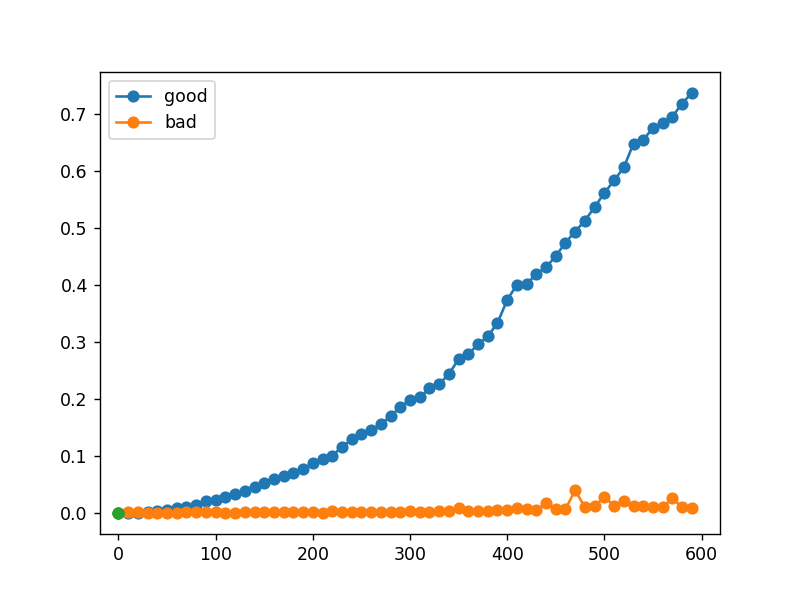

In [97]:
%matplotlib notebook

plt.plot(k, time_good, '-o', label = "good")
plt.plot(k, time_bad, '-o',label = "bad")

plt.legend()
plt.show()

In [171]:
Z = gen_hess(3000)
A = gen_rand_mat(5000*np.random.rand(3000))

In [172]:
print(runtime(QR_decomp_hesse, Z ))
print(runtime(np.linalg.qr, A ))
print(runtime(np.linalg.qr, Z))

18.480576038360596
0.6223361492156982
0.6592366695404053
